In [1]:
import numpy as np
import matplotlib.pyplot as plt

def logistic_map(length, r=4.0, x0=0.6):
    x = np.zeros(length)
    x[0] = x0
    for n in range(1, length):
        x[n] = r * x[n-1] * (1 - x[n-1])
    return np.arange(length), x

def henon_map(length, a=1.4, b=0.3, x0=0.0, y0=0.0):
    x, y = np.zeros(length), np.zeros(length)
    x[0], y[0] = x0, y0
    for n in range(1, length):
        x[n] = 1 - a * x[n-1]**2 + y[n-1]
        y[n] = b * x[n-1]
    return np.arange(length), np.column_stack((x, y))

def rulkov_map(length, alpha=4.5, sigma=0.001, mu=0.001, x0=-1.0, y0=-3.5):
    x, y = np.zeros(length), np.zeros(length)
    x[0], y[0] = x0, y0
    for n in range(1, length):
        x[n] = (alpha / (1 + x[n-1]**2)) + y[n-1]
        y[n] = y[n-1] - mu * (x[n-1] + 1) + mu * sigma
    return np.arange(length), np.column_stack((x, y))

def mackey_glass(length, tau=17, beta=0.2, gamma=0.1, n_pow=10, x0=1.2, dt=1.0):
    x = np.full(length + tau, x0)
    for i in range(tau, length + tau):
        x_delay = x[i - tau]
        dx = beta * x_delay / (1 + x_delay**n_pow) - gamma * x[i-1]
        x[i] = x[i-1] + dt * dx
    t = np.arange(length) * dt
    return t, x[tau:]

def lorenz(length, sigma=10, rho=28, beta=8/3, dt=0.02, x0=1, y0=1, z0=1):
    def f(t, s): 
        x, y, z = s
        return np.array([sigma*(y-x), x*(rho-z)-y, x*y - beta*z])
    s = np.array([x0, y0, z0])
    sol = np.zeros((length, 3))
    sol[0] = s
    for i in range(1, length):
        k1 = f(0, s)
        k2 = f(0, s + dt*k1/2)
        k3 = f(0, s + dt*k2/2)
        k4 = f(0, s + dt*k3)
        s = s + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
        sol[i] = s
    return np.arange(length)*dt, sol

def rossler(length, a=0.2, b=0.2, c=5.7, dt=0.1, x0=0.1, y0=0.1, z0=0.1):
    def f(t, s):
        x, y, z = s
        return np.array([-y-z, x + a*y, b + z*(x - c)])
    s = np.array([x0, y0, z0])
    sol = np.zeros((length, 3))
    sol[0] = s
    for i in range(1, length):
        k1 = f(0, s)
        k2 = f(0, s + dt*k1/2)
        k3 = f(0, s + dt*k2/2)
        k4 = f(0, s + dt*k3)
        s = s + dt/6 * (k1 + 2*k2 + 2*k3 + k4)
        sol[i] = s
    return np.arange(length)*dt, sol

In [77]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def auto_esn(t_full, x_full, transient=500, max_evals=40, val_len=500):
    # === SAFE DATA SCALING ===
    t = t_full[transient:]
    raw = np.asarray(x_full[transient:], dtype=np.float64)
    if raw.ndim > 1:
        raw = raw[:, 0]  # take first component if multivariate
    minv, maxv = raw.min(), raw.max()
    if maxv == minv:
        return None  # degenerate
    data = 2 * (raw - minv) / (maxv - minv + 1e-12) - 1.0  # [-1, 1]
    print(f"Data scaled: [{minv:.4f}, {maxv:.4f}] → [-1, 1] | N = {len(data)}")

    train_len = min(3000, len(data)//3)
    init_len = 500

    from skopt import gp_minimize
    from skopt.space import Real, Integer

    space = [
        Integer(300, 2800, name='res_size'),
        Real(0.05, 0.95, name='a'),
        Real(0.4, 1.8, name='sr'),
        Real(0.01, 3.0, name='scaling'),
        Real(0.0, 0.99, name='sparsity'),
        Real(1e-10, 1e-2, prior='log-uniform', name='reg'),
        Real(0.0, 3e-4, name='noise'),
    ]

    def safe_esn(params):
        res_size, a, sr, scaling, sparsity, reg, noise = params
        res_size = int(res_size)
        np.random.seed(42)

        try:
            Win = (np.random.rand(res_size, 2) - 0.5) * scaling
            W = np.random.rand(res_size, res_size) - 0.5
            W[np.random.rand(res_size, res_size) < sparsity] = 0
            rho = np.max(np.abs(np.linalg.eigvals(W)))
            if rho > 0:
                W *= sr / rho

            X = np.zeros((2 + res_size, train_len - init_len))
            Yt = data[init_len + 1: train_len + 1].reshape(1, -1)

            x = np.zeros((res_size, 1))
            for i in range(train_len):
                u = data[i]
                z = Win @ np.array([[1.0], [u]]) + W @ x
                x = (1 - a) * x + a * np.tanh(z + noise * (np.random.rand(res_size, 1) - 0.5))
                x = np.clip(x, -50, 50)
                if i >= init_len:
                    X[:, i - init_len] = np.hstack((1.0, u, x.flatten()))

            # SAFE SOLVE
            reg_safe = max(reg, 1e-9)
            try:
                Wout = np.linalg.solve(X @ X.T + reg_safe * np.eye(X.shape[0]), X @ Yt.T).T
            except:
                return 1e20

            # VALIDATION
            Yv = np.zeros(val_len)
            u = data[train_len]
            x_val = x.copy()
            for i in range(val_len):
                z = Win @ np.array([[1.0], [u]]) + W @ x_val
                x_val = (1 - a) * x_val + a * np.tanh(z)
                x_val = np.clip(x_val, -50, 50)
                y = Wout @ np.hstack((1.0, u, x_val.flatten()))
                Yv[i] = y
                u = y

            mse = np.mean((data[train_len + 1: train_len + 1 + val_len] - Yv)**2)
            return float(mse) if np.isfinite(mse) else 1e20

        except:
            return 1e20

    print(f"Starting Bayesian optimization ({max_evals} trials)...")
    res = gp_minimize(
        safe_esn,
        space,
        n_calls=max_evals,
        n_random_starts=min(15, max_evals),
        acq_func='EI',
        acq_optimizer='lbfgs',
        random_state=42,
        verbose=True,
        n_jobs=1,  # ← CRITICAL: joblib + scipy LBFGS = NaN hell
    )

    best = res.x
    print("\n" + "="*60)
    print(" AUTO-ESN OPTIMIZATION COMPLETE ")
    print("="*60)
    print(f"Best MSE       : {res.fun:.3e}")
    print(f"res_size       : {int(best[0])}")
    print(f"leaking rate   : {best[1]:.3f}")
    print(f"spectral radius: {best[2]:.3f}")
    print(f"input scaling  : {best[3]:.3f}")
    print(f"sparsity       : {best[4]:.3f} ({100*best[4]:.1f}% zeros)")
    print(f"regularization : {best[5]:.2e}")
    print(f"noise level    : {best[6]:.2e}")
    print(f"scaling used   : [{minv:.4f}, {maxv:.4f}] → [-1,1]")
    print("="*60)

    return {
        'params': {
            'res_size': int(best[0]),
            'a': best[1],
            'spectral_radius': best[2],
            'input_scaling': best[3],
            'sparsity': best[4],
            'reg': best[5],
            'noise_level': best[6],
        },
        'mse': res.fun,
        'scale': (minv, maxv)
    }

# Prepare data

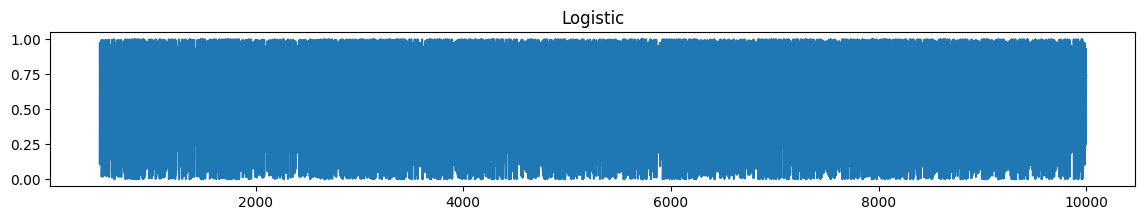

In [79]:
# Logistic Map
tansient = 500
n, x = logistic_map(10000, r=4.0)
t, x = n[tansient:], x[tansient:]

plt.figure(figsize=(14, 2))
plt.plot(t, x)
plt.title("Logistic")
plt.show()

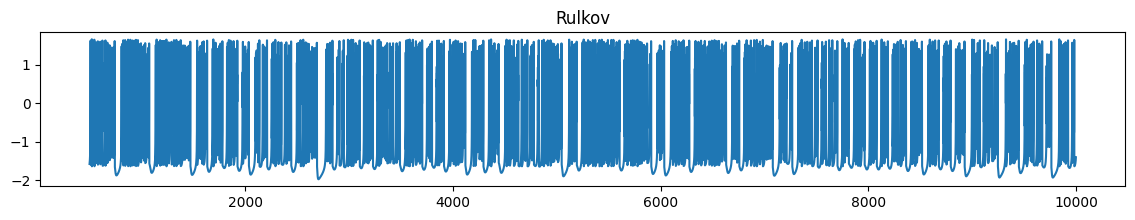

In [62]:
# Rulkov Map
tansient = 500
n, xy = rulkov_map(10000, alpha=4.5)
t, x = n[tansient:], xy[tansient:][:,0]

plt.figure(figsize=(14, 2))
plt.plot(t, x)
plt.title("Rulkov")
plt.show()

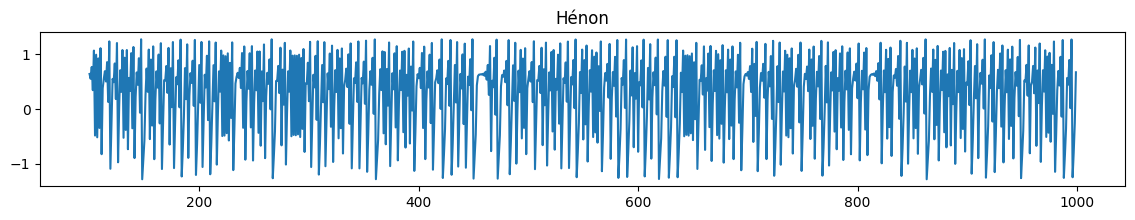

In [35]:
# Hénon Map
tansient = 100
n, xy = henon_map(10000)
t, x = n[tansient:], xy[tansient:][:,0]

plt.figure(figsize=(14, 2))
plt.plot(t, x)
plt.title("Hénon")
plt.show()

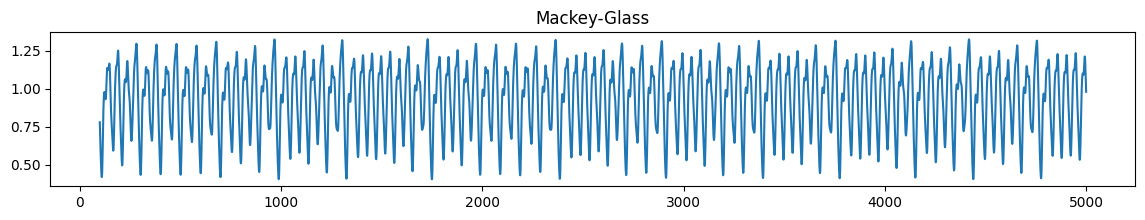

In [36]:
# Mackey-Glass
tansient = 100
t, x = mackey_glass(10000, tau=17)
t, x = t[tansient:], x[tansient:]

plt.figure(figsize=(14, 2))
plt.plot(t, x)
plt.title("Mackey-Glass")
plt.show()

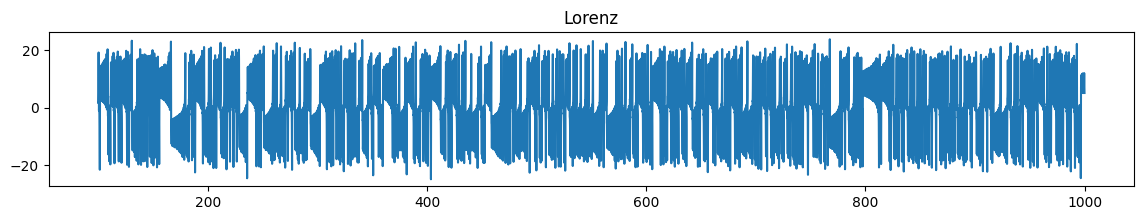

In [64]:
# Lorenz
tansient = 1000
t, xyz = lorenz(10000, dt=0.1)
t, x = t[tansient:], xyz[tansient:][:,1]

plt.figure(figsize=(14, 2))
plt.plot(t, x)
plt.title("Lorenz")
plt.show()

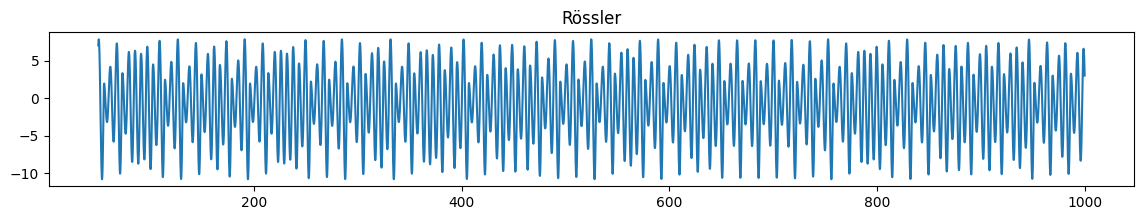

In [75]:
# Rössler
tansient = 500
t, xyz = rossler(10000, dt=0.1)
t, x = t[tansient:], xyz[tansient:][:,1]

plt.figure(figsize=(14, 2))
plt.plot(t, x)
plt.title("Rössler")
plt.show()

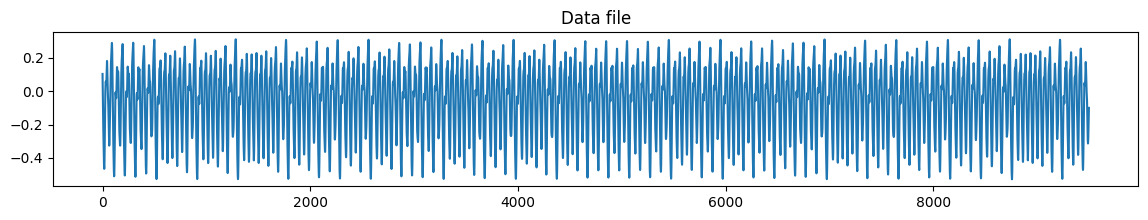

In [52]:
# Load data
tansient = 0
x = np.loadtxt('../data/MackeyGlass_t17.txt')[transient:]
t = np.arange(len(x))

plt.figure(figsize=(14, 2))
plt.plot(t, x)
plt.title("Data file")
plt.show()

# Grid search

In [80]:
params = auto_esn(t, x, transient=0, max_evals=50)

Data scaled: [0.0000, 1.0000] → [-1, 1] | N = 9500
Starting Bayesian optimization (50 trials)...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.5065
Function value obtained: 100000000000000000000.0000
Current minimum: 100000000000000000000.0000
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.5751
Function value obtained: 100000000000000000000.0000
Current minimum: 100000000000000000000.0000
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 7.6183
Function value obtained: 100000000000000000000.0000
Current minimum: 100000000000000000000.0000
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1291
Function value obtained: 100000000000000000000.0000
Current minimum

# Perform ESN prediction

In [72]:
# === ESN PARAMETERS ===
train_len = 2000
test_len  = 2000
init_len  = 100

res_size = params['params']['res_size']
a = params['params']['a']
spectral_radius = params['params']['spectral_radius']
input_scaling = params['params']['input_scaling']
sparsity = params['params']['sparsity']
noise_level = params['params']['noise_level']
reg = params['params']['reg']

In [ ]:
# === ESN PARAMETERS ===
train_len = 2000
test_len  = 2000
init_len  = 100

res_size = 1825
a = 0.612
spectral_radius = 1.741
input_scaling = 2.454
sparsity = 0.611
noise_level = 5.90e-05
reg = 1.26e-06
seed = 42

In [73]:
import numpy as np
import matplotlib.pyplot as plt

data = x

seed = 42
np.random.seed(seed)

# Weights
Win = (np.random.rand(res_size, 2) - 0.5) * input_scaling
W = np.random.rand(res_size, res_size) - 0.5
if sparsity > 0:
    W *= (np.random.rand(res_size, res_size) > sparsity)
rho = np.max(np.abs(np.linalg.eigvals(W)))
W *= spectral_radius / rho

# === TRAINING ===
X = np.zeros((2 + res_size, train_len - init_len))
# CORRECT: same length as X columns
Yt = data[init_len + 1: train_len + 1][None, :]   # (1, 1900)

x = np.zeros((res_size, 1))
for i in range(train_len):
    u = data[i]
    u_vec = np.vstack((1.0, u))

    z = Win @ u_vec + W @ x
    noise = noise_level * (np.random.rand(res_size, 1) - 0.5)
    x = (1 - a) * x + a * np.tanh(z + noise)

    if i >= init_len:
        X[:, i - init_len] = np.vstack((1, u, x))[:, 0]

# CORRECT ridge regression
I = np.eye(2 + res_size)
Wout = np.linalg.solve(X @ X.T + reg * I, X @ Yt.T).T   # exact same as original

# === PREDICTION ===
Y = np.zeros(test_len)
u = data[train_len]
x_pred = x.copy()

for i in range(test_len):
    u_vec = np.vstack((1.0, u))
    x_pred = (1 - a) * x_pred + a * np.tanh(Win @ u_vec + W @ x_pred)
    y = Wout @ np.vstack((1.0, u, x_pred))
    Y[i] = y
    u = y

# MSE
mse = np.mean((data[train_len+1:train_len+501] - Y[:500])**2)
print(f"MSE = {mse:.2e}")

MSE = 6.97e+00


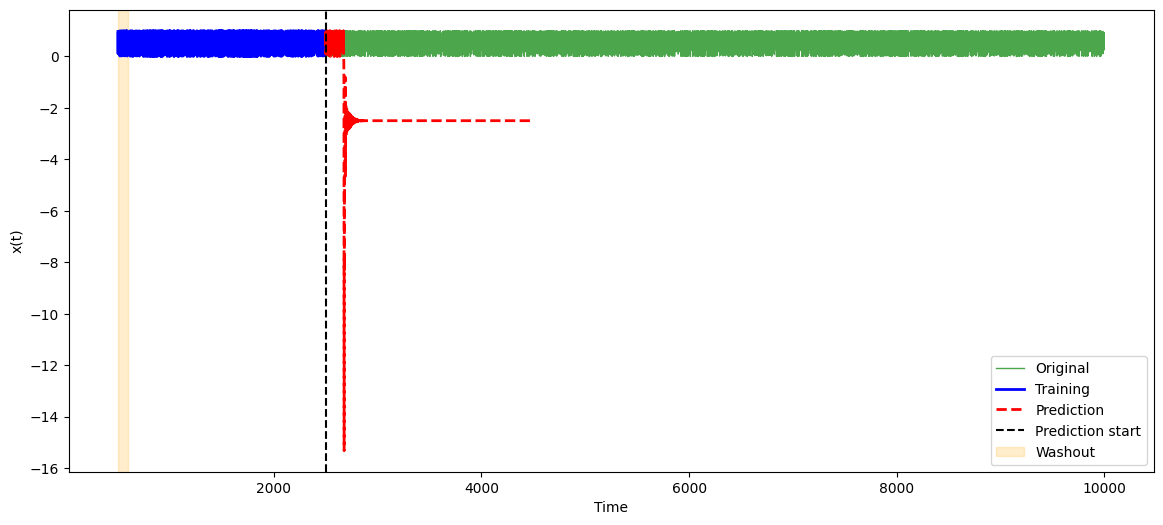

In [74]:
# === PLOT WITH TIME ===
t_train = t[:train_len+1]
t_pred = np.linspace(t[train_len], t[train_len] + test_len*np.mean(np.diff(t)), test_len)

plt.figure(figsize=(14, 6))
plt.plot(t, data, 'g', lw=1, alpha=0.7, label="Original")
plt.plot(t_train, data[:train_len+1], 'b', lw=2, label="Training")
plt.plot(t_pred, Y, 'r--', lw=2, label=f"Prediction")
plt.axvline(t[train_len], color='k', linestyle='--', lw=1.5, label="Prediction start")
plt.axvspan(t[0], t[init_len], color='orange', alpha=0.2, label="Washout")
#plt.xlim(2500, 4000)
plt.legend()
plt.xlabel("Time")
plt.ylabel("x(t)")
plt.show()